# Deep Reinforcement Learning for Portfolio Optimization - Temporal Self Attention

This experiment demonstrates the application of deep reinforcement learning (DRL) techniques for portfolio optimization.

- **Off-policy algorithms**: `SAC`, `DDPG`, `TD3` (use Temporal Self Attention-based models).  
- **On-policy algorithms**: `A2C`, `PPO` (do not use Temporal Self Attention-based models).

## Dependencies


In [4]:
# ! pip install pandas numpy matplotlib \
#                stable-baselines3 \
#                PyPortfolioOpt \
#                pandas_market_calendars quantstats gymnasium \
#                git+https://github.com/AI4Finance-Foundation/FinRL.git -q

In [48]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time

import torch
import torch.nn as nn
from torch.nn import TransformerEncoderLayer, LayerNorm

from stable_baselines3 import A2C, PPO, SAC, DDPG, TD3
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import (
    backtest_stats,
    get_daily_return,
    get_baseline, backtest_plot
)
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import (
    PortfolioOptimizationEnv,
)
from finrl.agents.portfolio_optimization.models import DRLAgent as PGAgent
from finrl.agents.portfolio_optimization.architectures import EIIE

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models

%matplotlib inline

In [6]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [8]:
experiment_name = "portfolio_optimization_mlp_multi_agent"
results_dir = f"results/models/{experiment_name}"
os.makedirs(results_dir, exist_ok=True)

## Data loading and pre-processing


Define training and trading/test periods


In [9]:
start_date = "2015-01-01"
end_date = (datetime.now() - pd.Timedelta(days=1)).strftime("%Y-%m-%d")  # Yesterday

trade_period = 2  # 2 years for testing
train_period = 10  # 10 years for training

train_end_date = (
    datetime.strptime(end_date, "%Y-%m-%d") - timedelta(days=trade_period * 365)
).strftime("%Y-%m-%d")
train_start_date = (
    datetime.strptime(train_end_date, "%Y-%m-%d") - timedelta(days=train_period * 365)
).strftime("%Y-%m-%d")
test_start_date = (
    datetime.strptime(train_end_date, "%Y-%m-%d") + timedelta(days=1)
).strftime("%Y-%m-%d")

train_dates = (train_start_date, train_end_date)
test_dates = (test_start_date, end_date)

print(f"Training period: {train_dates}")
print(f"Testing period: {test_dates}")

Training period: ('2013-05-04', '2023-05-02')
Testing period: ('2023-05-03', '2025-05-01')


- Fetch historical stock data for a given list of tickers within a specified date range.
- We use the DOW_30_TICKER stocks
- The data includes `date`, `close`, `high`, `low`, `open`, `volume`, and `tic` (ticker symbol).


In [10]:
def download_data(tickers, start_date, end_date):
    print(f"Downloading {start_date} → {end_date}")
    return YahooDownloader(
        start_date=start_date, end_date=end_date, ticker_list=tickers
    ).fetch_data()


# Uncomment the following line to use the DOW 30 tickers
# tickers = config_tickers.DOW_30_TICKER
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "TSLA", "JPM"]
df = download_data(tickers, start_date, end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (18179, 8)


### Feature Engineering

We apply feature engineering to the dataset of stock data:

- Add technical indicators (e.g., moving averages, RSI).
- Calculate turbulence indicators, which measure market volatility.

This Enhance the dataset with features that are critical for modeling market dynamics and making informed trading decisions.


In [11]:
def preprocess_data(df):
    fe = FeatureEngineer(
        use_technical_indicator=True,
        tech_indicator_list=["macd", "cci", "rsi", "dx"],  # TODO: Check
        use_turbulence=False,
    )
    return fe.preprocess_data(df)


df_feat = preprocess_data(df)

# TODO: Normalise the data??

Successfully added technical indicators


## Covariance & Returns for State


- Calculate the rolling covariance matrices and daily returns for the given dataset of stock prices.
- This prepares the state representation (the state of the portfolio) for the RL models in the RL environments for portfolio optimization.
- The **rolling covariance matrices** (`cov_list`) capture the relationships between asset returns, while the daily returns (`return_list`) provide information about recent price movements.
- These metrics are critical for modeling the dynamics of the financial market and making informed trading decisions.


In [12]:
def compute_covariance_and_returns(df_feat, lookback=252):
    df_sorted = df_feat.sort_values(["date", "tic"], ignore_index=True)
    df_sorted.index = df_sorted.date.factorize()[0]
    cov_list, return_list = [], []

    dates = df_sorted.date.unique()
    for i in range(lookback, len(dates)):
        win = df_sorted.loc[i - lookback : i]
        pm = win.pivot_table(index="date", columns="tic", values="close")
        rm = pm.pct_change().dropna()
        cov_list.append(rm.cov().values)
        return_list.append(rm)
    df_cov = pd.DataFrame(
        {"date": dates[lookback:], "cov_list": cov_list, "return_list": return_list}
    )

    return pd.merge(df_feat, df_cov, on="date", how="left").dropna(subset=["cov_list"])


df_all = compute_covariance_and_returns(df_feat)

## Train/Trade split


In [13]:
def split_data(df_all, train_dates, test_dates):
    train = data_split(df_all, *train_dates)
    test = data_split(df_all, *test_dates)
    return train, test


train_df, test_df = split_data(df_all, train_dates, test_dates)

## Environment setup


- Create instances of the **PortfolioOptimizationEnv** class for both training and testing datasets.
- It also wrap the training environment for use with Stable-Baselines3 (SB3).


In [14]:
def initialize_portfolio_env(df):
    env = PortfolioOptimizationEnv(
        df,
        initial_amount=100_000,
        comission_fee_pct=0.0025,
        time_window=50,
        features=["close", "high", "low"],
        normalize_df=None,
        new_gym_api=True,
    )

    env.df = df.reset_index(drop=True)

    return env


train_env = initialize_portfolio_env(train_df)
test_env = initialize_portfolio_env(test_df)

## Temporal Self Attention


Takes a Box(obs_shape=(f, n, t)) and returns a flat vector of size n * d_model,
where each asset’s t-step history of f features is run through a 1-layer TransformerEncoder.

In [65]:
class TemporalSelfAttention(BaseFeaturesExtractor):
    def __init__(self, observation_space, d_model=64, nhead=4):
        # the env’s obs shape is (features, n_assets, time_window)
        f, n_assets, time_window = observation_space.shape  
        super().__init__(observation_space, features_dim=n_assets * d_model)

        self.n_assets = n_assets
        self.time_window = time_window
        self.d_model = d_model

        # project f → d_model per timestep
        self.input_proj = nn.Linear(f, d_model)
        # single-layer transformer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)

    def forward(self, obs: torch.Tensor) -> torch.Tensor:
        # obs: [batch, f, n_assets, time_window]
        b, f, n, t = obs.shape

        # reorder → [batch, n_assets, time_window, f]
        x = obs.permute(0, 2, 3, 1)

        # project features → [batch, n_assets, time_window, d_model]
        x = self.input_proj(x)

        # merge batch+asset dims → [b*n, time_window, d_model]
        x = x.view(b * n, t, self.d_model)

        # run attention over the time axis
        x = self.transformer(x)           # [b*n, t, d_model]

        # mean-pool over time → [b*n, d_model]
        x = x.mean(dim=1)

        # restore batch → [batch, n_assets * d_model]
        return x.view(b, n * self.d_model)


## Model Configs


Configure model algorithms


In [ ]:
# obs_shape = train_env.observation_space.shape  # (features, n_assets, time_window)


def prepare_model_configs():
    policy_kwargs = dict(
        features_extractor_class=TemporalSelfAttention,
        features_extractor_kwargs=dict(
            d_model=64,  # embedding dim per asset
            nhead=4,  # number of attention heads
        ),
    )

    return [
        (
            SAC,
            "SAC",
            dict(
                learning_rate=0.0007,
                gamma=0.99,
                buffer_size=100_000,
                tau=0.005,
                policy_kwargs=policy_kwargs,
            ),
        ),
        (
            TD3,
            "TD3",
            dict(
                learning_rate=0.0007,
                gamma=0.99,
                buffer_size=100_000,
                tau=0.005,
                policy_kwargs=policy_kwargs,
            ),
        ),
        (
            DDPG,
            "DDPG",
            dict(
                learning_rate=0.0001,
                gamma=0.99,
                buffer_size=100_000,
                tau=0.005,
                policy_kwargs=policy_kwargs,
            ),
        ),
        # A2C/PPO entries will ignore the extractor.
        (
            A2C,
            "A2C",
            dict(
                learning_rate=0.0007,
                gamma=0.99,
                n_steps=5000,
                ent_coef=0.0001,
                policy_kwargs=dict(net_arch=[64, 64]),
            ),
        ),
        (
            PPO,
            "PPO",
            dict(
                learning_rate=0.0007,
                gamma=0.99,
                n_steps=2048,
                clip_range=0.2,
                policy_kwargs=dict(net_arch=[64, 64]),
            ),
        ),
    ]


model_configs = prepare_model_configs()

## Training


Train multiple reinforcement learning (RL) models using the specified training environment and configuration.


In [86]:
def train_models(agent, model_configs, results_dir, total_timesteps=200_000):
    training_times = {}
    trained_models = {}

    for model_class, model_name, model_kwargs in model_configs:
        print(f"Training {model_name}...")
        start_time = time.time()

        # 1) Copy your model_kwargs and pop off the policy_kwargs bundle
        mk = model_kwargs.copy()
        pk = mk.pop("policy_kwargs", {}) or {}

        # 2) If this is an *off-policy* algo, strip out use_sde flags
        if model_name.lower() in ("sac", "td3", "ddpg"):
            pk.pop("use_sde", None)
            pk.pop("use_sde_at_warmup", None)

        # 3) Call get_model exactly once with model_kwargs and policy_kwargs
        model = agent.get_model(
            model_name=model_name.lower(),
            model_kwargs=mk,
            policy_kwargs=pk,
        )

        trained_model = agent.train_model(
            model,
            tb_log_name=f"{experiment_name}_{model_name.lower()}",
            total_timesteps=total_timesteps,
        )

        # Save & record times
        model_path = f"{results_dir}/{model_name.lower()}_model"
        trained_model.save(model_path)
        trained_models[model_name] = trained_model
        training_times[model_name] = (time.time() - start_time) / 60
        print(f"{model_name} training completed in {training_times[model_name]:.2f} minutes.")

    return trained_models, training_times


In [ ]:
trained_models, training_times = train_models(
    DRLAgent(train_env), model_configs, results_dir
)

Training SAC...
{'learning_rate': 0.0007, 'gamma': 0.99, 'buffer_size': 100000, 'tau': 0.005}
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
training_times_df = pd.DataFrame(
    list(training_times.items()), columns=["model", "training_duration (min)"]
)
training_times_df.to_csv(f"{results_dir}/training_times.csv", index=False)

print("Training summary:")
display(training_times_df)

Training summary:


model  training_duration (min)
0   SAC                 0.004754
1   TD3                 0.002875
2  DDPG                 0.002781
3   A2C                 0.243470
4   PPO                 0.111040

## Model loading


Load the trained models from memory for analysis without the need for time consuming retraining


In [ ]:
def load_models(model_configs, results_dir):
    models = {}
    for model_class, name, _ in model_configs:
        model_path = f"{results_dir}/{name.lower()}_model.zip"
        if os.path.exists(model_path):
            print(f"Loading saved model for {name}...")
            models[name] = model_class.load(model_path)
        else:
            print(f"No saved model found for {name}.")
    return models


# If you already trained above you can skip this; otherwise:
# trained_models = load_models(model_configs, results_dir)

## Backtesting


- Evaluates the performance of the RL models/algorithms in a trading environment.
- We do this by calculating the **cumulative portfolio value** and **performance metrics** for each RL model.


In [ ]:
env_kwargs = {"initial_amount": 100_000}

In [ ]:
def manual_backtest(model, env, initial_amount):
    """
    Runs the env step by step, predicting actions with `model`, and
    builds a DataFrame of dates, daily returns, and account values.
    """
    # reset and get initial obs
    obs, _ = env.reset()
    done = False

    # start from initial capital
    portfolio_value = initial_amount

    dates, daily_rets, account_vals = [], [], []

    while not done:
        # predict an action
        action, _ = model.predict(obs, deterministic=True)
        # step the environment
        result = env.step(action)

        # handle gymnasium vs. gym return signature
        if len(result) == 5:
            obs, reward, terminated, truncated, info = result
            done = terminated or truncated
        else:
            obs, reward, done, info = result

        # update portfolio value from the reward
        portfolio_value *= 1 + reward

        # record
        daily_rets.append(reward)
        account_vals.append(portfolio_value)

        # grab the current date from info
        dates.append(info["end_time"])

    return pd.DataFrame(
        {
            "date": dates,
            "daily_return": daily_rets,
            "account_value": account_vals,
        }
    )


def backtest_rl_strategies_manual(models, test_env, env_kwargs):
    out = {}
    for name, model in models.items():
        print(f"\nManual backtest: {name}")
        df_ret = manual_backtest(model, test_env, env_kwargs["initial_amount"])
        # ensure it's sorted by date
        df_ret = df_ret.sort_values("date").reset_index(drop=True)

        # compute performance stats
        stats = backtest_stats(df_ret, value_col_name="account_value")
        out[name] = {"df": df_ret, "stats": stats}
    return out


results = backtest_rl_strategies_manual(trained_models, test_env, env_kwargs)


Manual backtest: SAC
Initial portfolio value:100000
Final portfolio value: 134035.03125
Final accumulative portfolio value: 1.3403502702713013
Maximum DrawDown: -0.2381324876083002
Sharpe ratio: 0.8649253430738514
Annual return          0.141369
Cumulative returns     0.266994
Annual volatility      0.215302
Sharpe ratio           0.722656
Calmar ratio           0.576051
Stability              0.826671
Max drawdown          -0.245411
Omega ratio            1.138722
Sortino ratio          1.046887
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.944797
Daily value at risk   -0.026508
dtype: float32

Manual backtest: TD3
Initial portfolio value:100000
Final portfolio value: 133044.203125
Final accumulative portfolio value: 1.3304420709609985
Maximum DrawDown: -0.23464138048409056
Sharpe ratio: 0.8538521817520602
Annual return          0.137741
Cumulative returns     0.259795
Annual volatility      0.212559
Sharpe ratio           0.714210
Calmar ra

### Plotting


Plotting SAC…


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (500, 8)


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/matplotlib/dates.py:449: UserWarning: no explicit representation of timezones available for np.datetime64
  d = d.astype('datetime64[us]')
/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


[*********************100%***********************]  1 of 1 completed

Plotting TD3…
Shape of DataFrame:  (500, 8)


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/matplotlib/dates.py:449: UserWarning: no explicit representation of timezones available for np.datetime64
  d = d.astype('datetime64[us]')
/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


[*********************100%***********************]  1 of 1 completed

Plotting DDPG…
Shape of DataFrame:  (500, 8)


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/matplotlib/dates.py:449: UserWarning: no explicit representation of timezones available for np.datetime64
  d = d.astype('datetime64[us]')
/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


[*********************100%***********************]  1 of 1 completed

Plotting A2C…
Shape of DataFrame:  (500, 8)


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/matplotlib/dates.py:449: UserWarning: no explicit representation of timezones available for np.datetime64
  d = d.astype('datetime64[us]')
/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


[*********************100%***********************]  1 of 1 completed

Plotting PPO…
Shape of DataFrame:  (500, 8)


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/matplotlib/dates.py:449: UserWarning: no explicit representation of timezones available for np.datetime64
  d = d.astype('datetime64[us]')
/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


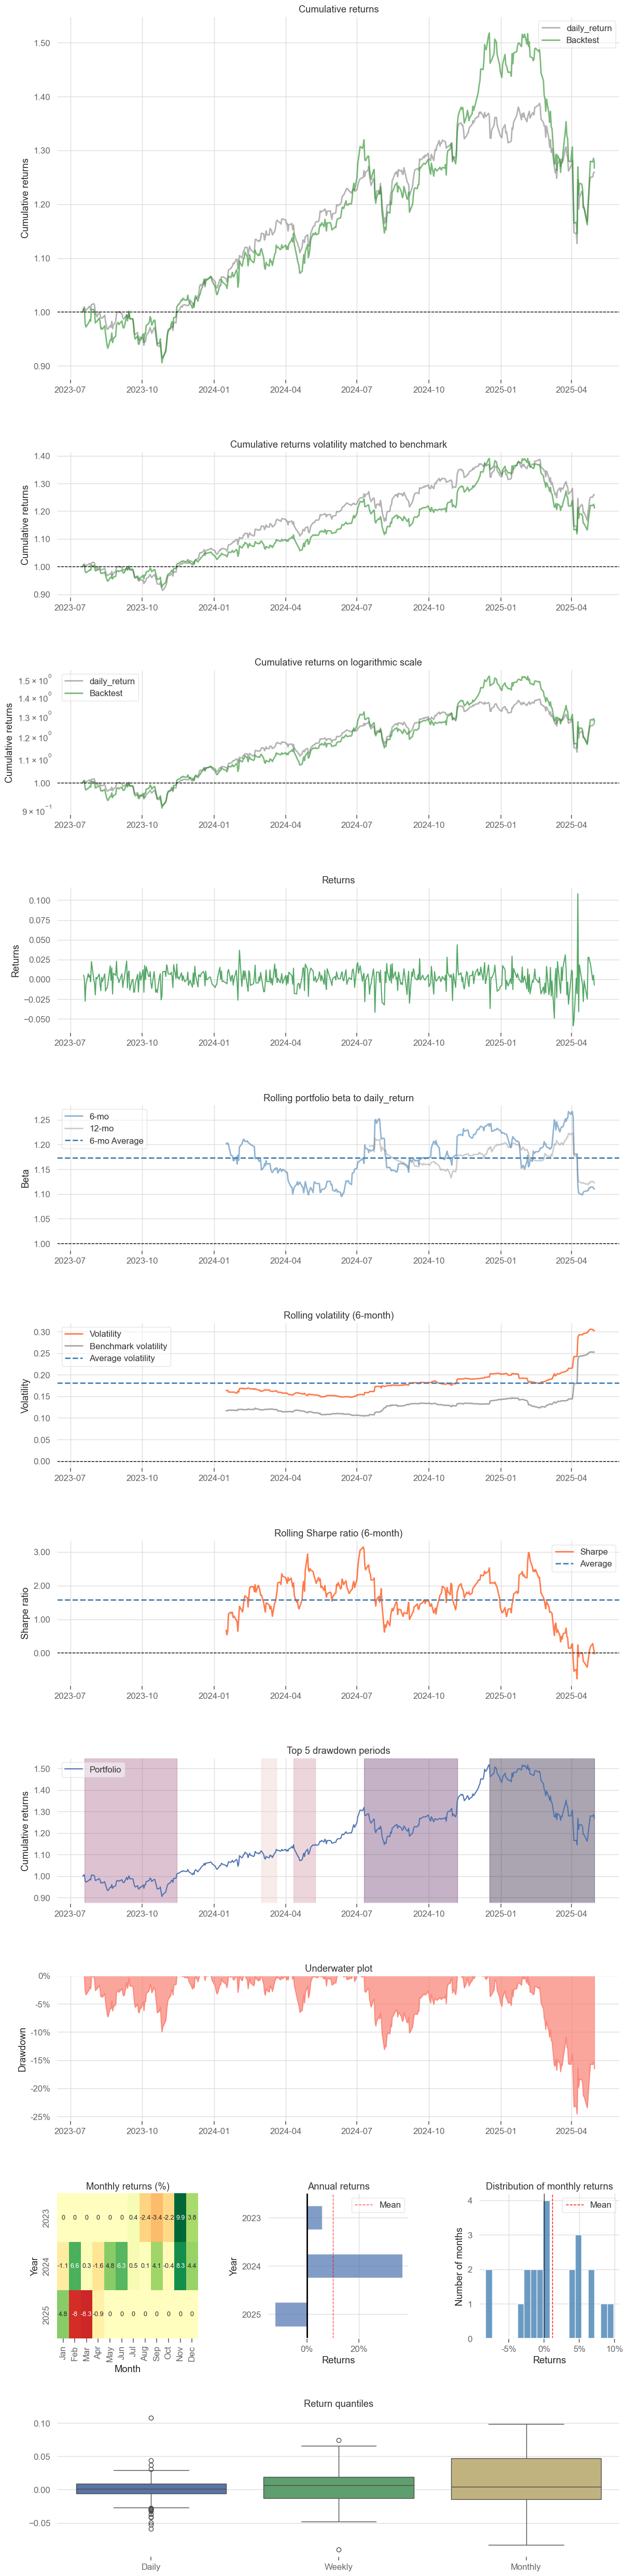

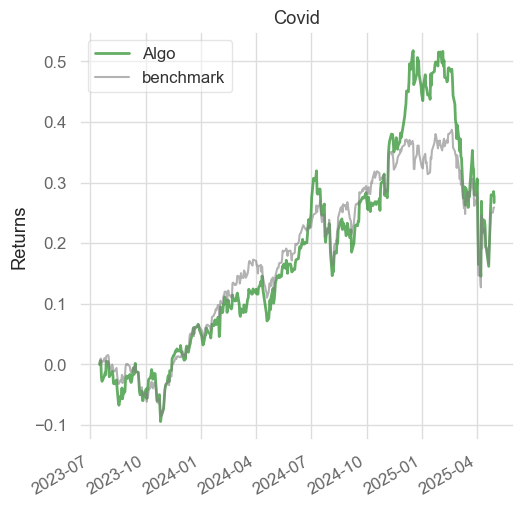

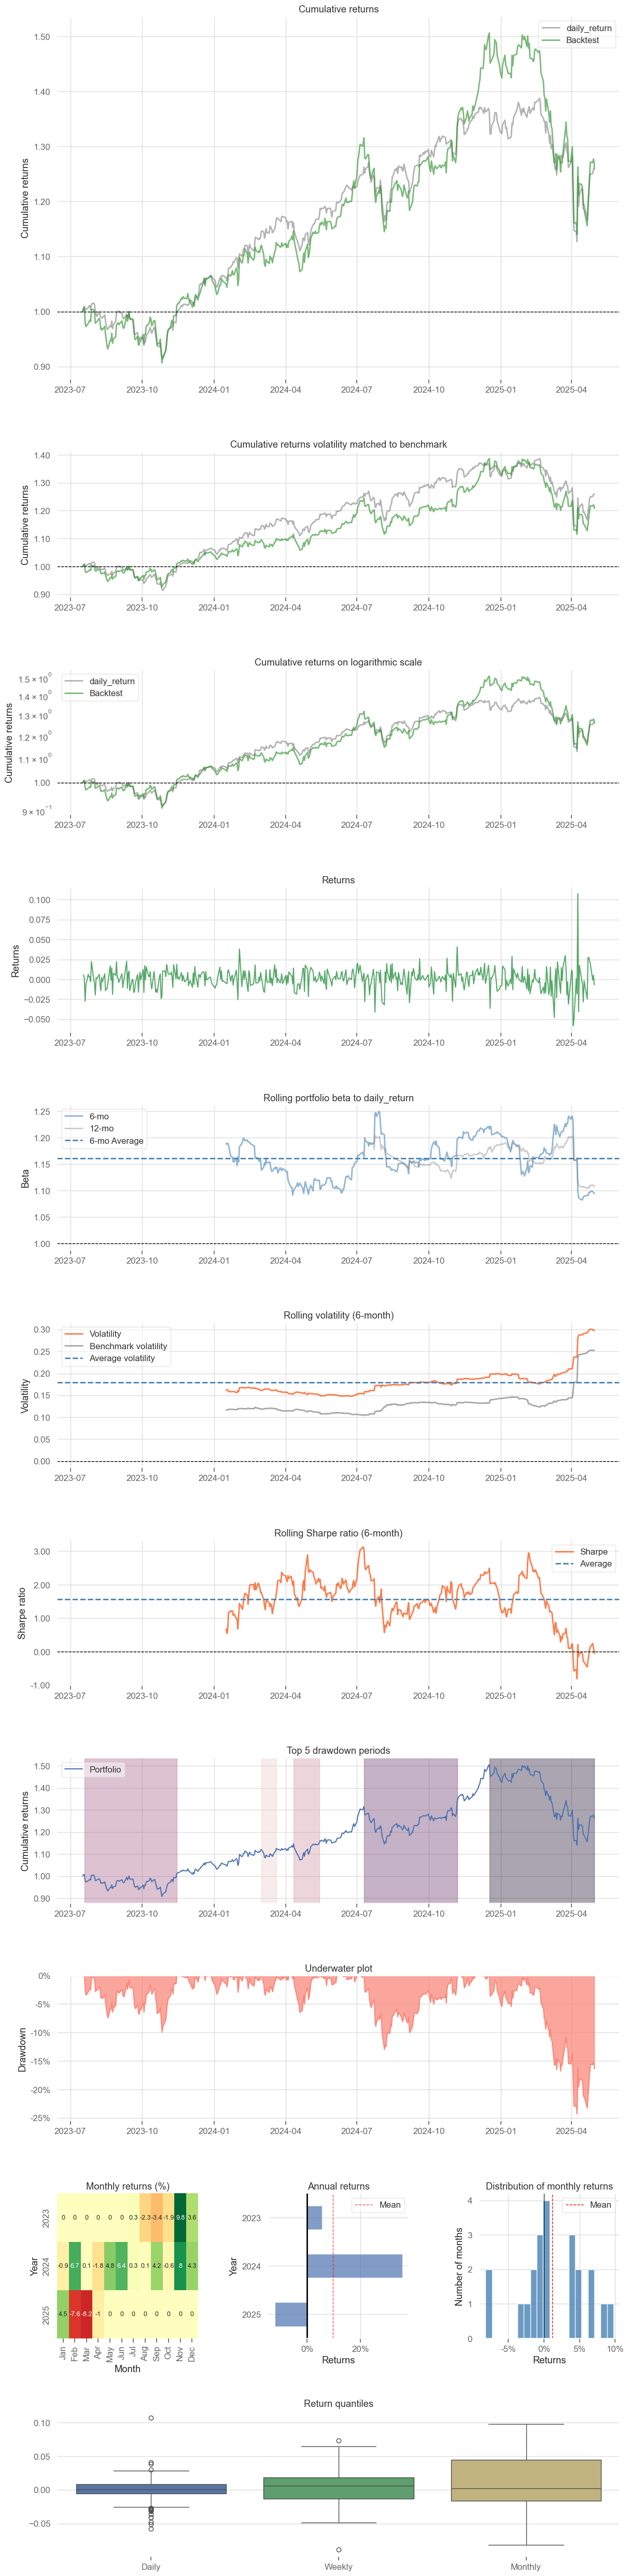

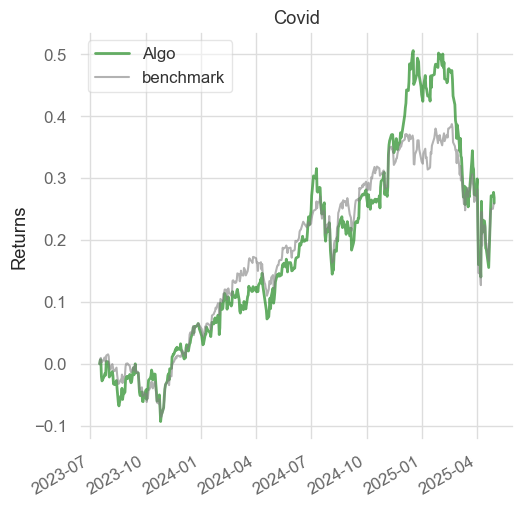

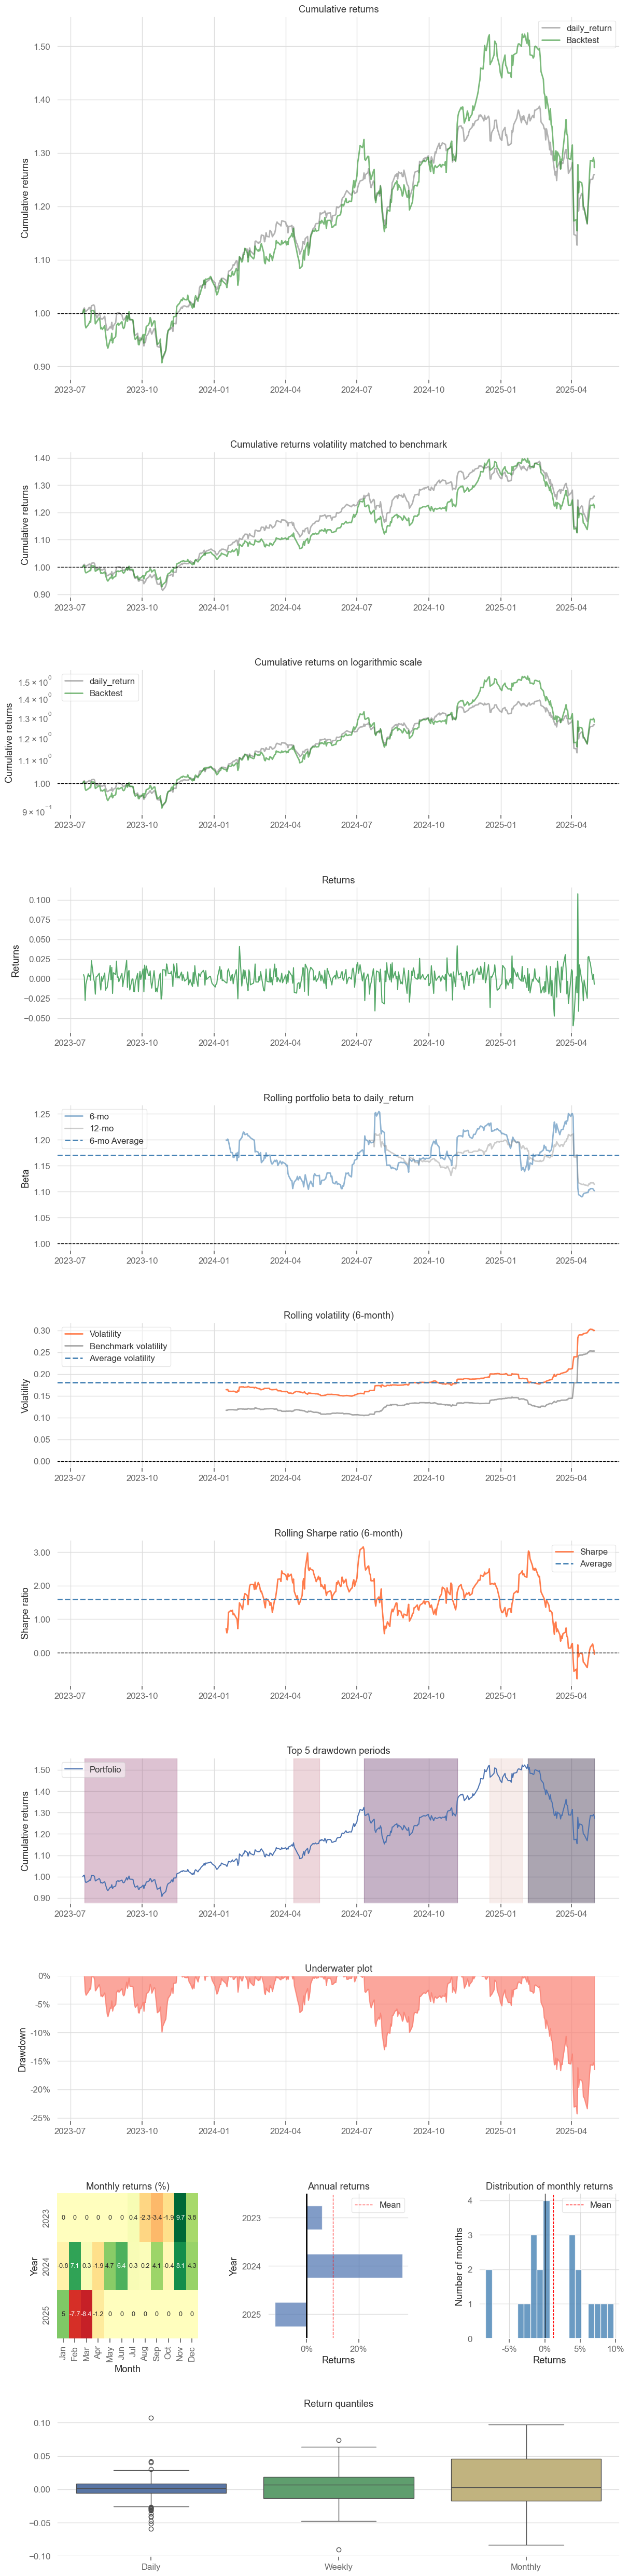

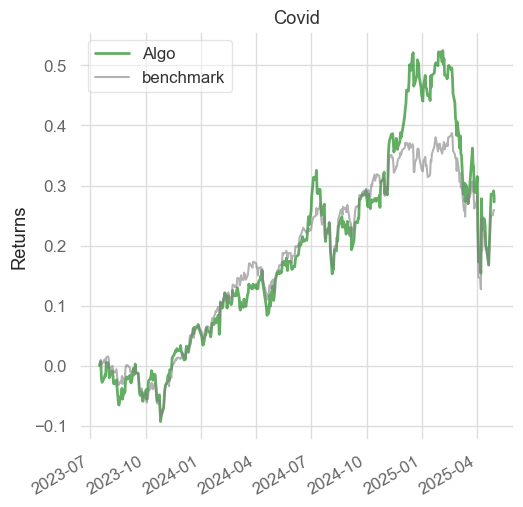

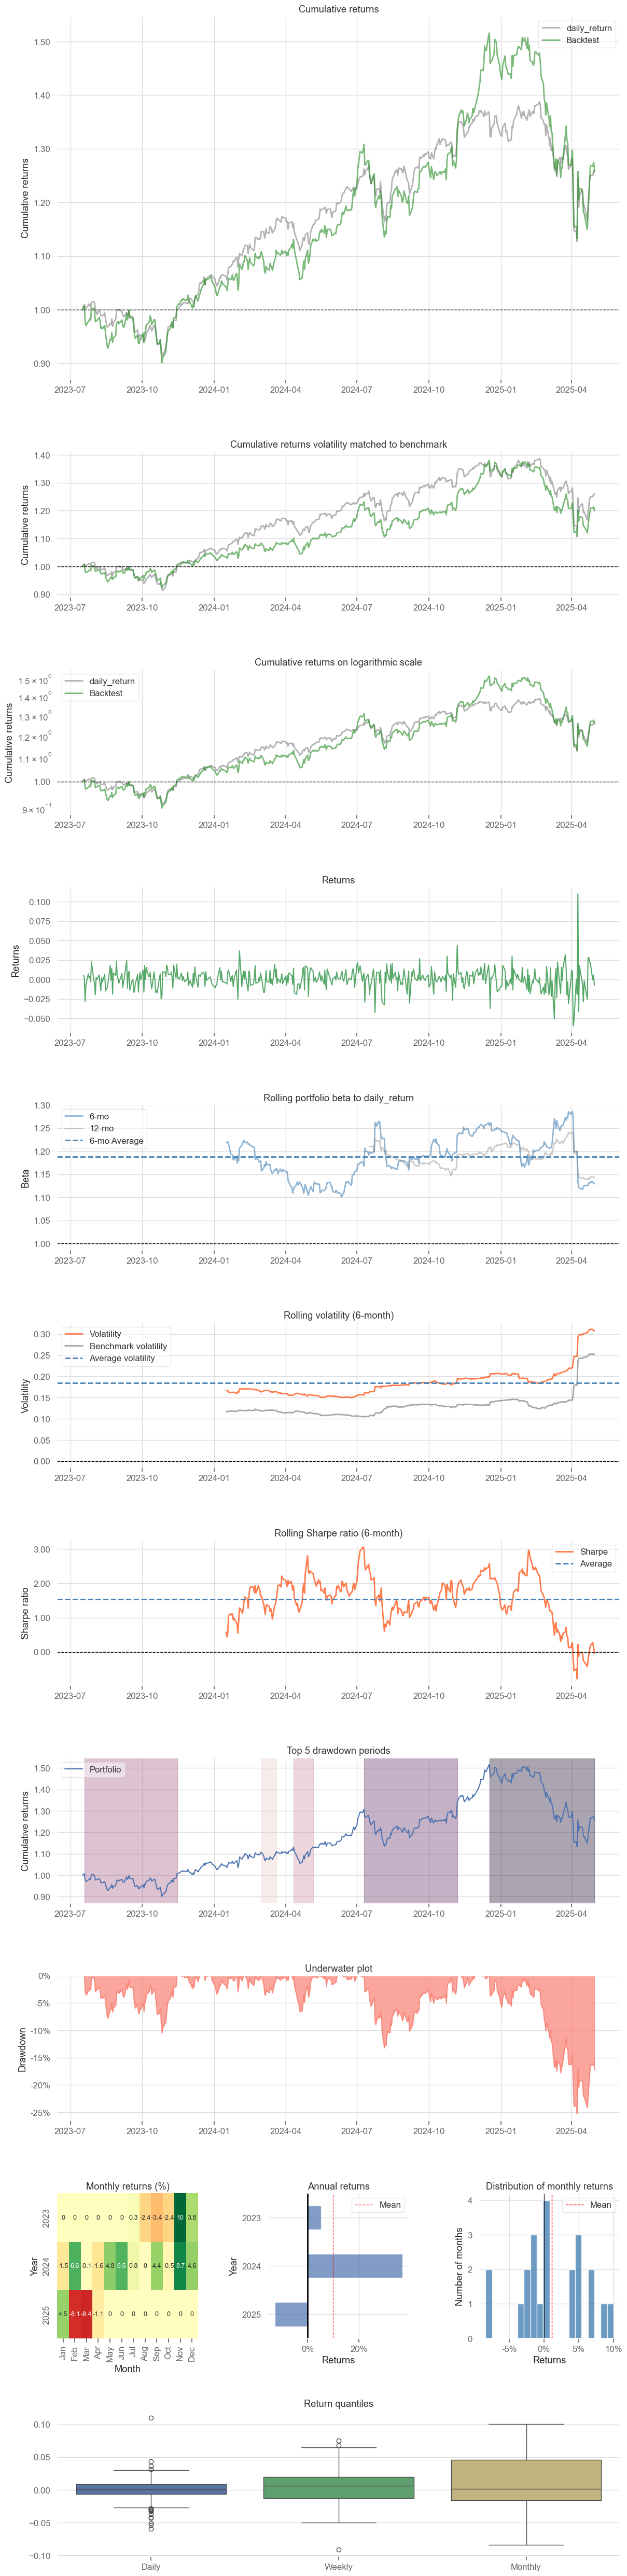

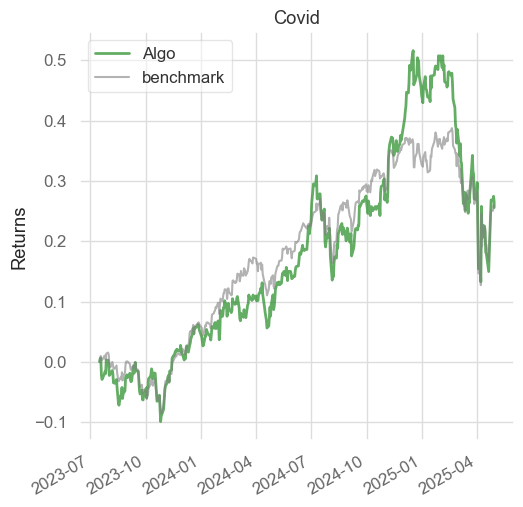

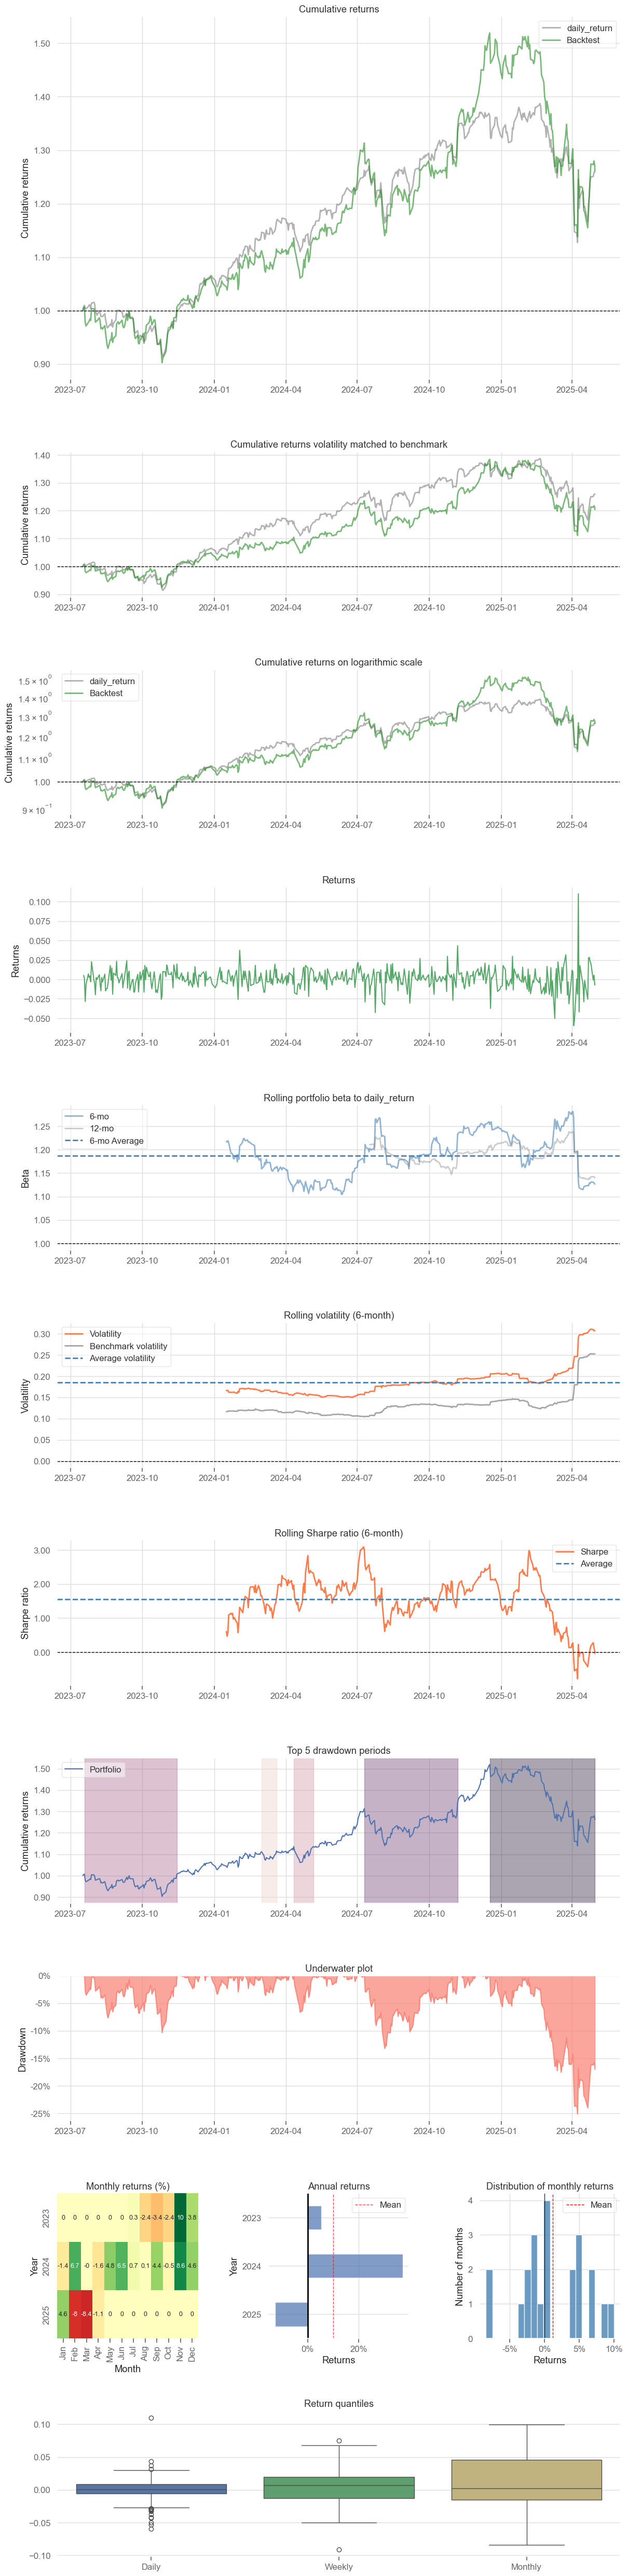

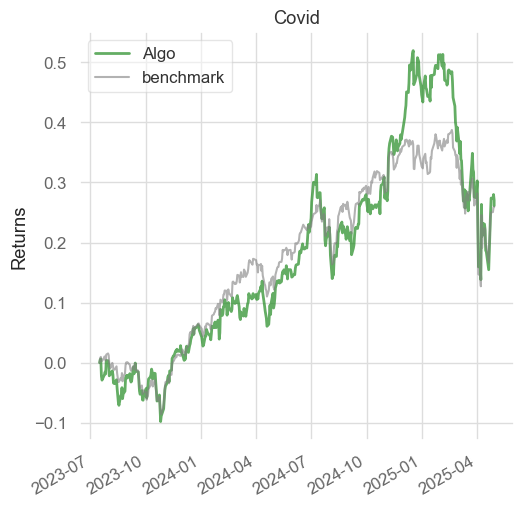

In [ ]:
def plot_backtest_results():
    os.makedirs(f"{results_dir}/backtest_plots", exist_ok=True)
    for name, res in results.items():
        print(f"Plotting {name}…")
        backtest_plot(
            account_value=res["df"],
            baseline_start=test_start_date,
            baseline_end=end_date,
            baseline_ticker="SPY",
            value_col_name="account_value",
        )


plot_backtest_results()

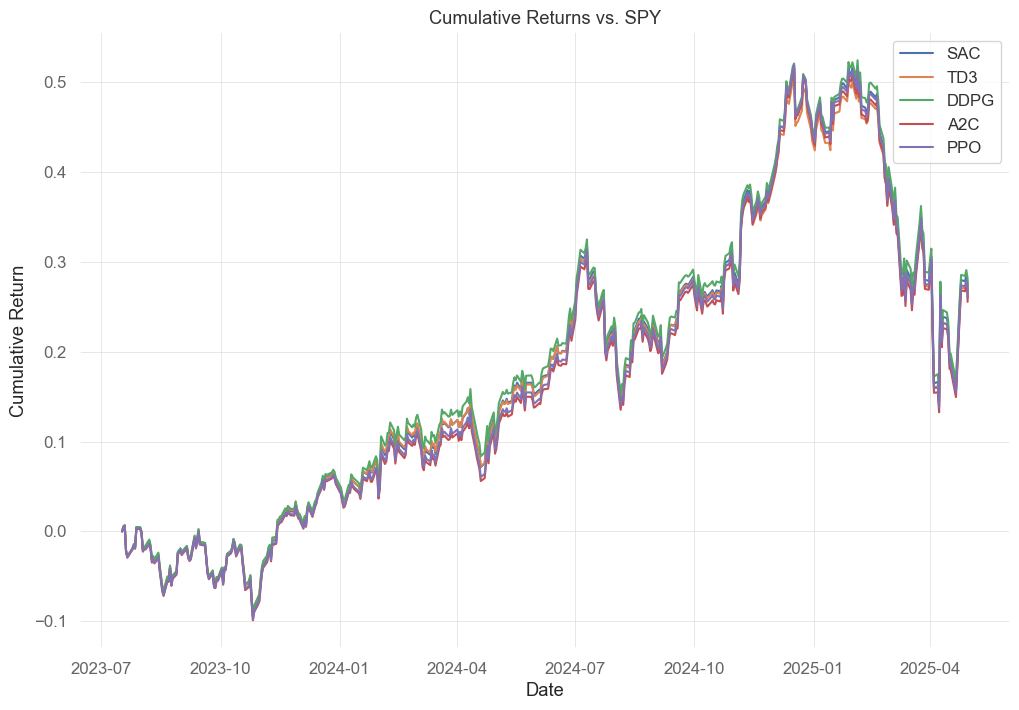

In [ ]:
def plot_cumulative_returns(results):
    plt.figure(figsize=(12, 8))
    for name, res in results.items():
        df = res["df"]
        # compute cumulative returns from account_value
        cum = df["account_value"] / df["account_value"].iloc[0] - 1
        plt.plot(df["date"], cum, label=name)
    plt.title("Cumulative Returns vs. SPY")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.show()


plot_cumulative_returns(results)

## Benchmarks


In [ ]:
def compute_mpt_benchmark(test, env_kwargs):
    dates_test = test.date.unique()
    min_vals = [env_kwargs["initial_amount"]]
    for i in range(len(dates_test) - 1):
        curr = test[test.date == dates_test[i]]
        nxt = test[test.date == dates_test[i + 1]]
        covm = np.array(curr.cov_list.values[0])
        ef = EfficientFrontier(None, covm, weight_bounds=(0, 1))
        ef.min_volatility()
        w = ef.clean_weights()
        prices = curr.close.values
        nextp = nxt.close.values
        shares = np.array(list(w.values())) * min_vals[-1] / prices
        min_vals.append(np.dot(shares, nextp))
    min_df = pd.DataFrame({"date": dates_test, "account_value": min_vals})
    stats_mpt = backtest_stats(min_df, value_col_name="account_value")
    return {"df": min_df, "stats": stats_mpt}


mpt_benchmark = compute_mpt_benchmark(test_df, env_kwargs)

Annual return          0.237778
Cumulative returns     0.526916
Annual volatility      0.184996
Sharpe ratio           1.247700
Calmar ratio           1.100416
Stability              0.893750
Max drawdown          -0.216080
Omega ratio            1.264836
Sortino ratio          1.864391
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.967217
Daily value at risk   -0.022391
dtype: float64


In [ ]:
def compute_equal_weighted_benchmark(test, env_kwargs):
    ew_daily = test.groupby("date")["close"].apply(
        lambda d: d.pct_change().fillna(0).mean()
    )

    ew_df = ew_daily.reset_index(name="daily_return")
    ew_df["account_value"] = (ew_df.daily_return + 1).cumprod() * env_kwargs[
        "initial_amount"
    ]
    stats_ew = backtest_stats(ew_df, value_col_name="account_value")
    return {"df": ew_df, "stats": stats_ew}


ew_benchmark = compute_equal_weighted_benchmark(test_df, env_kwargs)

Annual return          1.581128e+13
Cumulative returns     1.543215e+26
Annual volatility      4.247318e-01
Sharpe ratio           7.639716e+01
Calmar ratio                    NaN
Stability              9.963876e-01
Max drawdown           0.000000e+00
Omega ratio                     NaN
Sortino ratio                   inf
Skew                            NaN
Kurtosis                        NaN
Tail ratio             1.907665e+00
Daily value at risk    7.525192e-02
dtype: float64


In [ ]:
def compute_equal_weighted_benchmark(df, initial_amount=100_000):
    # Pivot to have one column per ticker
    price_wide = df.pivot_table(
        index="date", columns="tic", values="close"
    ).sort_index()

    # Compute each ticker's daily return, then average equally
    daily_rets = price_wide.pct_change().fillna(0).mean(axis=1)

    # Build the equity curve
    ew_df = pd.DataFrame({"date": daily_rets.index, "daily_return": daily_rets.values})
    ew_df["account_value"] = (ew_df["daily_return"] + 1).cumprod() * initial_amount

    # Compute performance statistics
    stats_ew = backtest_stats(ew_df, value_col_name="account_value")

    return {"df": ew_df.reset_index(drop=True), "stats": stats_ew}


ew_benchmark = compute_equal_weighted_benchmark(test_df, env_kwargs["initial_amount"])

Annual return          0.335091
Cumulative returns     0.774309
Annual volatility      0.244754
Sharpe ratio           1.305140
Calmar ratio           1.241374
Stability              0.884065
Max drawdown          -0.269935
Omega ratio            1.261796
Sortino ratio          1.957439
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.976577
Daily value at risk   -0.029568
dtype: float64


In [ ]:
def compute_spy_benchmark(test, env_kwargs):
    spy_close = get_baseline("SPY", test.date.min(), test.date.max())["close"]
    spy_ret = spy_close.pct_change().dropna()
    spy_df = pd.DataFrame({"date": spy_ret.index, "daily_return": spy_ret.values})
    spy_df["account_value"] = (spy_df.daily_return + 1).cumprod() * env_kwargs[
        "initial_amount"
    ]
    stats_spy = backtest_stats(spy_df, value_col_name="account_value")
    return {"df": spy_df, "stats": stats_spy}


spy_benchmark = compute_spy_benchmark(test_df, env_kwargs)

[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (499, 8)
Annual return          0.188071
Cumulative returns     0.405733
Annual volatility      0.163918
Sharpe ratio           1.135001
Calmar ratio           1.002765
Stability              0.871185
Max drawdown          -0.187552
Omega ratio            1.244568
Sortino ratio          1.690122
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.914007
Daily value at risk   -0.019913
dtype: float64


In [ ]:
benchmarks = {
    "MPT": mpt_benchmark,
    "EW": ew_benchmark,
    "SPY": spy_benchmark,
}

results.update(benchmarks)

## Performance Summary


In [ ]:
perf_stats = pd.DataFrame({key.upper(): res["stats"] for key, res in results.items()})
display(perf_stats)

SAC       TD3      DDPG       A2C       PPO  \
Annual return        0.141369  0.137741  0.144166  0.135631  0.138440   
Cumulative returns   0.266994  0.259795  0.272555  0.255617  0.261181   
Annual volatility    0.215302  0.212559  0.214200  0.219274  0.218896   
Sharpe ratio         0.722656  0.714210  0.736739  0.690414  0.702549   
Calmar ratio         0.576051  0.567039  0.592972  0.536609  0.551724   
Stability            0.826671  0.825695  0.831198  0.818864  0.822623   
Max drawdown        -0.245411 -0.242913 -0.243124 -0.252756 -0.250923   
Omega ratio          1.138722  1.136868  1.141616  1.132027  1.134539   
Sortino ratio        1.046887  1.034737  1.067159  1.000884  1.018522   
Skew                      NaN       NaN       NaN       NaN       NaN   
Kurtosis                  NaN       NaN       NaN       NaN       NaN   
Tail ratio           0.944797  0.943755  0.941928  0.957328  0.951410   
Daily value at risk -0.026508 -0.026177 -0.026360 -0.027025 -0.026968   

                          MPT        EW       SPY  
Annual return        0.237778  0.335091  0.188071  
Cumulative returns   0.526916  0.774309  0.405733  
Annual volatility    0.184996  0.244754  0.163918  
Sharpe ratio         1.247700  1.305140  1.135001  
Calmar ratio         1.100416  1.241374  1.002765  
Stability            0.893750  0.884065  0.871185  
Max drawdown        -0.216080 -0.269935 -0.187552  
Omega ratio          1.264836  1.261796  1.244568  
Sortino ratio        1.864391  1.957439  1.690122  
Skew                      NaN       NaN       NaN  
Kurtosis                  NaN       NaN       NaN  
Tail ratio           0.967217  0.976577  0.914007  
Daily value at risk -0.022391 -0.029568 -0.019913

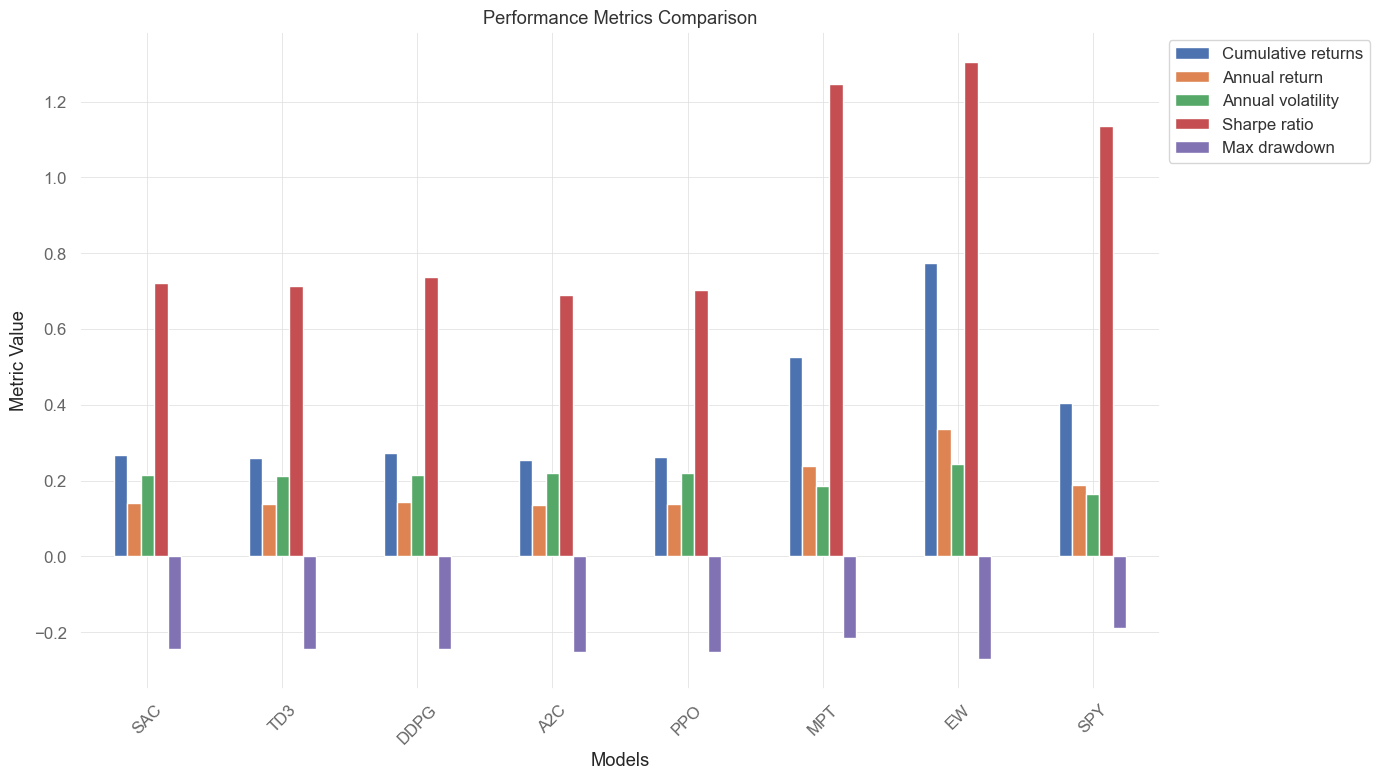

In [ ]:
metrics_to_include = [
    "Cumulative returns",
    "Annual return",
    "Annual volatility",
    "Sharpe ratio",
    "Max drawdown",
]
filtered_perf_stats = perf_stats.loc[metrics_to_include]

filtered_perf_stats.T.plot(kind="bar", figsize=(14, 8), legend=True)
plt.title("Performance Metrics Comparison")
plt.ylabel("Metric Value")
plt.xlabel("Models")
plt.xticks(rotation=45)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

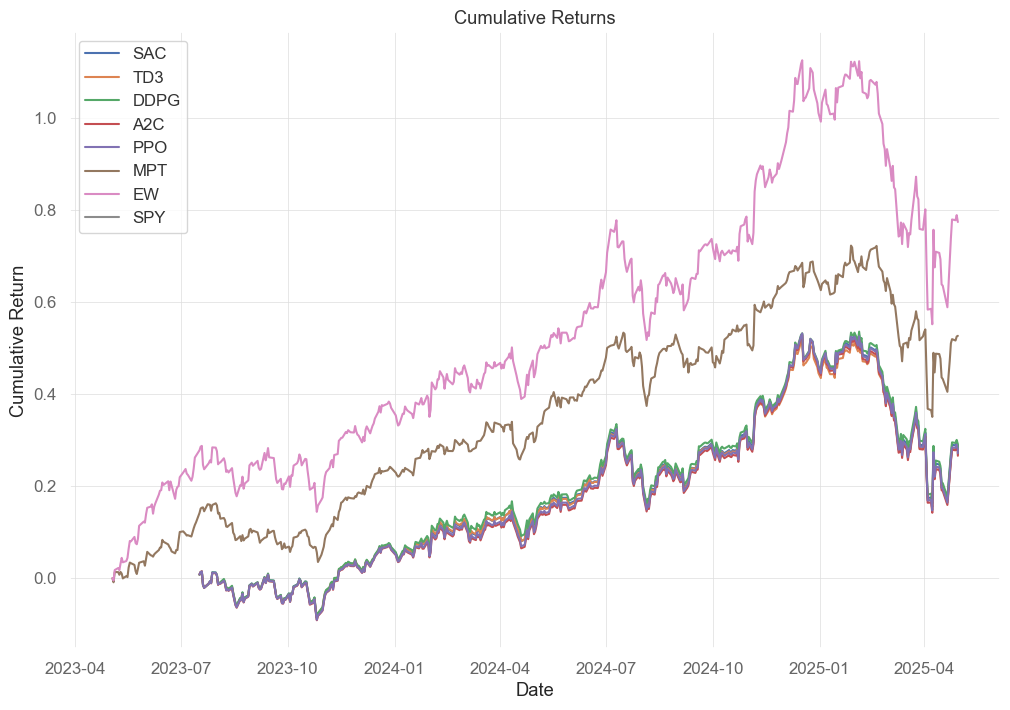

In [ ]:
def plot_cumulative_returns(results):
    plt.figure(figsize=(12, 8))
    for name, res in results.items():
        # Ensure the date column is converted to datetime
        res["df"]["date"] = pd.to_datetime(res["df"]["date"])
        # Filter data to start from the trade start date
        filtered_df = res["df"][res["df"]["date"] >= test_start_date]
        cum = (
            (filtered_df["daily_return"] + 1).cumprod() - 1
            if "daily_return" in filtered_df
            else filtered_df["account_value"] / filtered_df["account_value"].iloc[0] - 1
        )
        plt.plot(filtered_df["date"], cum, label=name)
    plt.title("Cumulative Returns")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.show()


plot_cumulative_returns(results)